In [105]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime
import re
import pickle

# Data Read In

In [50]:
def try_convert_float(x):
    try:
        return float(x)
    except:
        return x
    
def try_convert_int(x):
    try:
        return int(x)
    except:
        return x

df = pd.read_csv('/Users/wanwx011/Desktop/simple_recommender_sys/src/data/recommendations_take_home.csv')
df['order_created_at'] = df['order_created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df['catalog_item_id'] = df['catalog_item_id'].apply(lambda x: try_convert_int(x))
df['quantity'] = df['quantity'].apply(lambda x: try_convert_int(x))
df['volume'] = df['volume'].apply(lambda x: try_convert_float(x))

# EDA

Dataset appears to be fairly clean in general. No major data issues

In [78]:
num_cols = [
   'catalog_item_id',
    'quantity', 
    'volume'
]

cat_cols = [
    'catalog_item_name',
    'top_level_category', 
    'brand_name',
    'is_gift',
    'device',
    'volume_units',
    'subcategory',
    'tasting_notes', 
    'beer_features', 
    'wine_features', 
    'wine_body',
    'beer_body', 
    'liquor_flavor', 
    'food_pairing', 
    'white_wine_style',
    'red_wine_style', 
    'description'
]

In [13]:
df.shape

(549296, 23)

In [14]:
df[num_cols].describe()

,catalog_item_id,quantity,volume
count,549296.000000,549296.000000,547978.000000
mean,23278.854690,1.474607,367.054222
std,33838.773464,1.516702,363.156161
min,3.000000,1.000000,0.000000
25%,2026.000000,1.000000,12.000000
50%,4868.000000,1.000000,187.000000
75%,26197.000000,1.000000,750.000000
max,130610.000000,201.000000,900.000000


In [17]:
df[cat_cols].isna().sum()

catalog_item_name          0
top_level_category        32
brand_name              1015
is_gift                  103
device                     0
volume_units            1230
subcategory               32
tasting_notes         278001
beer_features         507539
wine_features         523106
wine_body             417252
beer_body             433607
liquor_flavor         533254
food_pairing          270259
white_wine_style      423075
red_wine_style        473410
description            21124
dtype: int64

In [18]:
df[num_cols].isna().sum()

catalog_item_id       0
quantity              0
volume             1318
dtype: int64

In [19]:
for i in cat_cols:
    print(df.groupby(i)[i].count())
    print("-----")

catalog_item_name
 7 Deadly Cabernet Sauvignon                                        6
 7 Deadly Red Blend                                                 4
 Agnes & Rene Mosse Moussamoussettes Petillant Rosé                 1
 Beso Del Sol® White Sangria White Wine, Spain                      7
 Buchanan's Special Reserve Aged 18 Years Blended Scotch Whisky    21
                                                                   ..
anCnoc 12 Year Single Malt Scotch                                   1
anCnoc 24 Year Single Malt Scotch                                   1
d'Arenberg Footbolt Shiraz                                         10
d'Arenberg Stump Jump GSM                                           3
iichiko Shochu Saiten                                               5
Name: catalog_item_name, Length: 13721, dtype: int64
-----
top_level_category
Beer      158840
Extras     47117
Liquor    137265
Wine      206042
Name: top_level_category, dtype: int64
-----
brand_name
1+1=3     

# Data Filtration

Exclude gift items because it doesn't necessarily reflect the account holder's taste;

Since the recommender system suffers from cold start problem, only keep users that have purchased no less than 3 products;

Also try to identify some business accounts as it has different behavior compare with personal accounts, and thus might bring in noises into the recommendation system. 

In [51]:
print('original #users,', df.groupby(['user_id_hash', 'catalog_item_id']).size().groupby('user_id_hash').size().to_frame().shape[0])
print('original #unique item purchased,', df.groupby(['user_id_hash', 'catalog_item_id']).size().to_frame().shape[0])

original #users, 75499
original #unique item purchased, 387601


In [52]:
# exclude gift items
df = df[df['is_gift']!=True]
# count number of unique purchased item for each user
df_interaction = df.groupby(['user_id_hash', 'catalog_item_id']).size().groupby('user_id_hash').size().to_frame().reset_index().rename(columns={0:'#unique item purchased'})

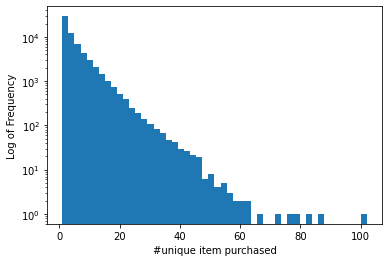

In [46]:
plt.hist(df_interaction['#unique item purchased'], bins=50, log=True)
plt.xlabel("#unique item purchased")
plt.ylabel('Log of Frequency')
plt.show()

In [53]:
# remove one outlier - potential business account 
df = df[~df['user_id_hash'].isin(df_interaction[df_interaction['#unique item purchased']>100]['user_id_hash'].to_list())]
# remove users who have purchased < 3 different products
user_list = df_interaction[df_interaction['#unique item purchased']>=3]['user_id_hash'].to_list()
df = df[df['user_id_hash'].isin(user_list)].reset_index(drop=True)


In [55]:
print('#users who purchased no less than 3 different products,', df.groupby(['user_id_hash', 'catalog_item_id']).size().groupby('user_id_hash').size().to_frame().shape[0])
print('#unique item puchased that meets criteria,', df.groupby(['user_id_hash', 'catalog_item_id']).size().to_frame().shape[0])

#users who purchased no less than 3 different products, 44033
#unique item puchased that meets criteria, 327945


# Interaction Matrix Formation & Train/Test Split

The purpose of our recommender system to suggest Top N items for each user. Thus we first summarize the raw data frame into a user|item interaction chart, which records what items each user has purchased. The total number of purchased quantity for each item by each user is also recorded because it reflects how much the user likes the item, and thus can serve as the strength of signals.

Use leave-one-out method to split train and test. 

In [56]:
# produce a list of user/item interactions
df_chart = df.groupby(['user_id_hash', 'catalog_item_id'])['quantity'].sum().to_frame().reset_index().rename(columns={'quantity':'#total purchased quantity'})
# train and test split
df_test = df_chart.groupby('user_id_hash').apply(lambda x: x.sample(1)).reset_index(drop=True)
df_test['type'] = 'test'
df_chart = pd.merge(df_chart, df_test[['user_id_hash', 'catalog_item_id', 'type']], on=['user_id_hash', 'catalog_item_id'], how='left')
df_chart['type'] = df_chart['type'].fillna('train')
df_train = df_chart[df_chart['type']=='train'].set_index('user_id_hash')
df_test = df_test.set_index('user_id_hash')


In [57]:
df_train.head()

,catalog_item_id,#total purchased quantity,type
user_id_hash,,,
0001107f3626adb7b68c97d300026dd8,1173,1,train
0001107f3626adb7b68c97d300026dd8,83255,1,train
00060fa17b02360e574bb75e72291204,313,1,train
00060fa17b02360e574bb75e72291204,1621,2,train
00060fa17b02360e574bb75e72291204,4585,1,train


In [58]:
df_test.head()

,catalog_item_id,#total purchased quantity,type
user_id_hash,,,
0001107f3626adb7b68c97d300026dd8,9439,3,test
00060fa17b02360e574bb75e72291204,43575,1,test
00078680e4a6b39eb4077d0d18ad43f5,98257,2,test
000a984b1f8df5dc7d08ff18f7771594,5240,8,test
000b168d2437f5fea949479ca015f623,13867,4,test


# Model - Content Based Filtering

The goal is to build a content based filtering algorithm using product text attributes. Texts and descriptions of each product is combined and vectorized. Then construct a text based user profile for each user based on the purchased items. To make recommendations, calculate the cosine similarity between the text of the other items and the user profile.

## Step 1 - Generate a list of products with their description texts

In [86]:
# generate a df for products only
df_product_full_profile = df[['catalog_item_id', 'catalog_item_name', 'top_level_category', 'brand_name', 'subcategory', 'tasting_notes', 'beer_features', 'wine_features', 'wine_body', 'beer_body', 'liquor_flavor', 'food_pairing', 'white_wine_style', 'red_wine_style', 'description']]
df_product_full_profile = df_product_full_profile.fillna("")
df_product_full_profile['text'] = df_product_full_profile['catalog_item_name'] + " " + df_product_full_profile['subcategory'] + " " + df_product_full_profile['tasting_notes'] + " " + df_product_full_profile['beer_features'] + " " + df_product_full_profile['wine_features'] + " " + df_product_full_profile['wine_body'] + " " + df_product_full_profile['beer_body'] + " " + df_product_full_profile['liquor_flavor'] + " " + df_product_full_profile['food_pairing'] + " " + df_product_full_profile['white_wine_style'] + " " + df_product_full_profile['red_wine_style'] + " " + df_product_full_profile['description']
df_product_full_profile.sort_values("catalog_item_id", inplace = True) 
df_product_full_profile.drop_duplicates(subset ="catalog_item_id", keep = 'first', inplace = True) 
df_product_full_profile = df_product_full_profile.reset_index(drop=True)
df_product = df_product_full_profile[['catalog_item_id','text']]
regex = re.compile('[^a-zA-Z]')
df_product['text'] = df_product['text'].apply(lambda x: regex.sub(' ', x.lower()))

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [87]:
df_product.head()

,catalog_item_id,text
0,3,standing stone riesling ice wine prosecco ...
1,6,starborough sauvignon blanc white wine ci...
2,8,chateau ste michelle merlot red wine cas...
3,9,chateau ste michelle riesling white wine ...
4,10,steak house cabernet sauvignon red wine c...


In [88]:
df_product_full_profile.head()

,catalog_item_id,catalog_item_name,top_level_category,brand_name,subcategory,tasting_notes,beer_features,wine_features,wine_body,beer_body,liquor_flavor,food_pairing,white_wine_style,red_wine_style,description,text
0,3,Standing Stone Riesling Ice Wine,Wine,Standing Stone,Prosecco,,,,,,,,,,"""With its charming yellow farmhouse and its wi...",Standing Stone Riesling Ice Wine Prosecco ...
1,6,Starborough Sauvignon Blanc,Wine,Starborough,White Wine,"[\n ""Citrus"",\n ""Tropical Fruit"",\n ""Vegeta...",,,Light,,,"[\n ""Shellfish"",\n ""Salads & Greens""\n]",Fruity & Crisp,,Starborough Sauvignon Blanc has refreshing fla...,"Starborough Sauvignon Blanc White Wine [\n ""C..."
2,8,Chateau Ste. Michelle Merlot,Wine,Chateau Ste. Michelle,Red Wine,"[\n ""Cassis"",\n ""Dark Fruit"",\n ""Jammy"",\n ...",,,Medium,,,"[\n ""Mushrooms"",\n ""Beef""\n]",Big & Bold,Big & Bold,We craft this wine to be our complex yet appro...,"Chateau Ste. Michelle Merlot Red Wine [\n ""Ca..."
3,9,Chateau Ste. Michelle Riesling,Wine,Chateau Ste. Michelle,White Wine,"[\n ""Crisp"",\n ""Apple"",\n ""Minerality""\n]",,,Light,,,"[\n ""Cheese - Blue"",\n ""Cheese - Creamy & Bl...",Sweet & Bold,,"Clean and fresh, this juicy wine carries a bit...",Chateau Ste. Michelle Riesling White Wine [\n ...
4,10,Steak House Cabernet Sauvignon,Wine,Steak House,Red Wine,"[\n ""Currant"",\n ""Floral"",\n ""Vanilla"",\n ...",,,Full,,,"[\n ""Beef"",\n ""Lamb""\n]",Big & Bold,Big & Bold,Deep color leads with aromatics of blackberry ...,"Steak House Cabernet Sauvignon Red Wine [\n ""..."


In [114]:
df_product_full_profile.to_csv("products.csv", index=False)

## Step 2 - Generate a vectorize profile for each product

In [89]:
# content based tf-idf. unigram or bigram
stopwords_list = stopwords.words('english')

vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = df_product['catalog_item_id'].tolist()
tfidf_matrix = vectorizer.fit_transform(df_product['text'])
tfidf_feature_names = vectorizer.get_feature_names()

In [109]:
pickle.dump(tfidf_matrix, open("tfidf_matrix.pickle", "wb"))
pickle.dump(tfidf_feature_names, open("tfidf_feature.pickle", "wb"))
pickle.dump(item_ids, open("item_ids.pickle", "wb"))

## Step 3 - Generate a vectorize profile for each user

In [90]:
# take all products the user has purchased and weighted average by purchased units
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    ids = pd.Series(ids)
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(user_id_hash, df_index):
    # get a list of purchased product for each user
    interactions_df = df_index.loc[user_id_hash]
    # get tf-idf matrix for each product for each user
    user_product_vector = get_item_profiles(interactions_df['catalog_item_id'])
    # weighted average by the number of units purchased
    weights = np.array(interactions_df['#total purchased quantity']).reshape(-1,1)
    user_product_vector_avg = np.sum(user_product_vector.multiply(weights), axis=0) / np.sum(weights)
    user_product_norm = sklearn.preprocessing.normalize(user_product_vector_avg)
    return user_product_norm
    
user_profiles = {}
for user_id_hash in df_train.index.unique():
    user_profiles[user_id_hash] = build_users_profile(user_id_hash, df_train)
    

## Step 4 - Generate recommendation lists based on the similarity between user profiles and item profiles

In [64]:
def get_items_interacted(user_id_hash, df_chart):
    interacted_items = df_train[df_train.index==user_id_hash]['catalog_item_id']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

def generate_recommendation(user_id_hash, topn=20):
    # calculate cosine similarity between each user's profile and each product 
    cosine_similarities = cosine_similarity(user_profiles[user_id_hash], tfidf_matrix)
    # select top n items to form a recommendation list
    similar_indices = cosine_similarities.argsort().flatten()[-topn:]
    similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
    # ignore the items that user has already purchased in the recommendation list
    items_to_ignore = get_items_interacted(user_id_hash, df_chart)
    similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
    recommendations_df = pd.DataFrame(similar_items_filtered, columns=['catalog_item_id', 'recStrength'])
    recommendations_df = pd.merge(recommendations_df, df_product_full_profile, on = 'catalog_item_id', how = 'left')
    return recommendations_df

## Step 5 - Model Performance

Use hit rate to measure the model performance. If the test item appears in the recommended list, it is then considered to be one hit. Then summarize all hit numbers and divided by the number of users to get the hit rate

In [103]:
user_list = df_test.index.to_list()
sum_hit = 0
for user in user_list:
    test_item = df_test.loc[user]['catalog_item_id']
    recommendation_df = generate_recommendation(user, topn=20)
    if test_item in recommendation_df['catalog_item_id'].to_list():
        sum_hit += 1
    else:
        sum_hit += 0
hit_rate = sum_hit/len(user_list)
print("hit_rate", hit_rate)

hit_rate 0.030045647582494946


## Example

In [21]:
def showcase_user_profile(user_id_hash):
    myprofile = user_profiles[user_id_hash]
    user_profile_output = pd.DataFrame(sorted(zip(tfidf_feature_names, user_profiles[user_id_hash].flatten().tolist()), key=lambda x: -x[1])[:20], columns=['token', 'relevance'])
    return user_profile_output

def showcase_user_purchase_history(user_id_hash):
    return (df_chart[df_chart['user_id_hash']==user_id_hash].merge(df_product_full_profile, on='catalog_item_id', how='left'))

def showcase_recommendation_list(user_id_hash):
    return generate_recommendation(user_id_hash, topn=20)
    
    

In [91]:
user_id_hash = '000a984b1f8df5dc7d08ff18f7771594'
print("user profile,")
showcase_user_profile(user_id_hash)

user profile,


,token,relevance
0,melon,0.266739
1,honeydew,0.259194
2,sonoma,0.250694
3,coast,0.224315
4,chardonnay,0.187990
5,lemon,0.174835
6,chicken,0.162774
7,sauvignon blanc,0.159527
8,richly,0.148541
9,white,0.147136


In [92]:
print("user purchase history,")
showcase_user_purchase_history(user_id_hash)

user purchase history,


,user_id_hash,catalog_item_id,#total purchased quantity,type,catalog_item_name,top_level_category,brand_name,subcategory,tasting_notes,beer_features,wine_features,wine_body,beer_body,liquor_flavor,food_pairing,white_wine_style,red_wine_style,description,text
0,000a984b1f8df5dc7d08ff18f7771594,1335,4,train,La Crema Sonoma Coast Chardonnay,Wine,La Crema,White Wine,"[\n ""Citrus"",\n ""Melon - Honeydew"",\n ""Ston...",,"[\n ""Oak Aged""\n]",Full,,,"[\n ""Chicken"",\n ""Shellfish""\n]",Rich & Velvety,,"A round, light, and balanced Chardonnay from C...",La Crema Sonoma Coast Chardonnay White Wine [\...
1,000a984b1f8df5dc7d08ff18f7771594,2633,2,train,Chateau Ste. Michelle Sauvignon Blanc,Wine,Chateau Ste. Michelle,White Wine,"[\n ""Bright"",\n ""Dark Fruit"",\n ""Melon"",\n ...",,,Light,,,"[\n ""Shellfish"",\n ""Chicken""\n]",Fruity & Crisp,,Tasting Notes The mostly stainless steel fe...,Chateau Ste. Michelle Sauvignon Blanc White Wi...
2,000a984b1f8df5dc7d08ff18f7771594,5240,8,test,Kendall-Jackson Vintner's Reserve Cabernet Sau...,Wine,Kendall-Jackson,Red Wine,"[\n ""Cassis"",\n ""Mocha"",\n ""Round"",\n ""Sup...",,"[\n ""Oak Aged""\n]",Full,,,"[\n ""Beef"",\n ""Cheese - Hard Aged""\n]",Big & Bold,Big & Bold,"Aromas of lush black cherry, blackberry and ca...",Kendall-Jackson Vintner's Reserve Cabernet Sau...


In [93]:
print("recommendation list,")
showcase_recommendation_list(user_id_hash)

recommendation list,


,catalog_item_id,recStrength,catalog_item_name,top_level_category,brand_name,subcategory,tasting_notes,beer_features,wine_features,wine_body,beer_body,liquor_flavor,food_pairing,white_wine_style,red_wine_style,description,text
0,2207,0.468072,[ yellow tail ] Chardonnay,Wine,Yellow Tail,White Wine,"[\n ""Peach"",\n ""Melon - Honeydew"",\n ""Vanil...",,,Full,,,"[\n ""Chicken"",\n ""Salads & Greens""\n]",Rich & Velvety,,A blend of selected parcels of fruit from some...,"[ yellow tail ] Chardonnay White Wine [\n ""Pe..."
1,2963,0.431547,Decoy Sonoma County Sauvignon Blanc,Wine,Decoy,White Wine,"[\n ""Grapefruit"",\n ""Stone Fruit"",\n ""Melon...",,,Light,,,"[\n ""Shellfish"",\n ""Salads & Greens""\n]",Fruity & Crisp,,This enticing Sauvignon Blanc is fermented ent...,Decoy Sonoma County Sauvignon Blanc White Wine...
2,1913,0.410337,Bota Box Sauvignon Blanc,Wine,Bota Box,White Wine,"[\n ""Nectarine"",\n ""Melon - Honeydew"",\n ""C...",,,Light,,,"[\n ""Chicken"",\n ""Salads & Greens""\n]",Fruity & Crisp,,Bota Box Sauvignon Blanc offers lively aromas ...,"Bota Box Sauvignon Blanc White Wine [\n ""Nect..."
3,4772,0.388805,Sonoma-Cutrer Sonoma Coast Chardonnay White Wine,Wine,Sonoma-Cutrer,White Wine,"[\n ""Peach"",\n ""Apple"",\n ""Caramel""\n]",,,Full,,,"[\n ""Chicken"",\n ""Salads & Greens""\n]",Rich & Velvety,,Its uncompromising methods of vineyard managem...,Sonoma-Cutrer Sonoma Coast Chardonnay White Wi...
4,8453,0.381103,Patz & Hall Sonoma Chardonnay,Wine,Patz & Hall,White Wine,"[\n ""Citrus"",\n ""Minerality"",\n ""Oak""\n]",,,Full,,,"[\n ""Fish - Meaty & Oily"",\n ""Shellfish"",\n ...",Rich & Velvety,,Our Sonoma Coast Chardonnay embodies the diver...,Patz & Hall Sonoma Chardonnay White Wine [\n ...
5,12155,0.375200,Gato Negro Sauvignon Blanc,Wine,Gato Negro,White Wine,"[\n ""Citrus"",\n ""Herbal"",\n ""Light"",\n ""Me...",,,Light,,,"[\n ""Cheese - Creamy & Bloomy"",\n ""Salads & ...",Fruity & Crisp,,"A vivacious, fresh young wine with a bouquet o...","Gato Negro Sauvignon Blanc White Wine [\n ""Ci..."
6,3368,0.364706,Flowers Sonoma Coast Chardonnay,Wine,Flowers Vineyards and Winery,White Wine,"[\n ""Balanced"",\n ""Bright"",\n ""Citrus"",\n ...",,"[\n ""Eco-Friendly"",\n ""Oak Aged"",\n ""Organi...",Full,,,"[\n ""Cheese - Fresh & Soft"",\n ""Chicken"",\n ...",Fruity & Crisp,,94 Points (JS) | 94 Points (WE)\n\nThe dramati...,Flowers Sonoma Coast Chardonnay White Wine [\n...
7,2888,0.359623,Cupcake® Vineyards Chardonnay White Wine,Wine,Cupcake,White Wine,"[\n ""Apple"",\n ""Butter"",\n ""Citrus"",\n ""Cr...",,"[\n ""Oak Aged"",\n ""Screw Cap""\n]",Full,,,"[\n ""Fish - White"",\n ""Shellfish"",\n ""Turke...",Rich & Velvety,,Cupcake Vineyards' Chardonnay is crafted with ...,Cupcake® Vineyards Chardonnay White Wine White...
8,15083,0.358495,Gallo Family Vineyards Sauvignon Blanc,Wine,Gallo Family Vineyards,White Wine,,,,Light,,,"[\n ""Chicken"",\n ""Cheese - Fresh & Soft""\n]",Fruity & Crisp,,Our Sauvignon Blanc balances the fruit flavors...,Gallo Family Vineyards Sauvignon Blanc White W...
9,10837,0.347993,"Benziger Sauvignon Blanc White Wine - 750ml, N...",Wine,Benziger,White Wine,"[\n ""Bright"",\n ""Citrus"",\n ""Crisp"",\n ""Fr...",,"[\n ""Eco-Friendly"",\n ""Screw Cap""\n]",Light,,,"[\n ""Chicken"",\n ""Cheese - Fresh & Soft""\n]",Fruity & Crisp,,"Fresh and elegant, our Sauvignon Blanc invites...","Benziger Sauvignon Blanc White Wine - 750ml, N..."


# Cold Start - Popularity Recommendation

In [132]:
top_20_popular = df.groupby('catalog_item_id')['quantity'].sum().to_frame().reset_index().sort_values('quantity', ascending=False).head(20)
top_20_popular['score'] = top_20_popular['quantity']/sum(top_20_popular['quantity'])
most_popular_items = pd.merge(top_20_popular[['catalog_item_id', 'score']], df_product_full_profile[['catalog_item_id','catalog_item_name', 'brand_name']], on='catalog_item_id', how='left')
recommend_list = []
for index, row in most_popular_items.iterrows():
    recommend_list.append(row.to_dict())


In [135]:
recommend_list

[{'catalog_item_id': 304,
  'score': 0.11892656847843178,
  'catalog_item_name': "Tito's Handmade Vodka",
  'brand_name': "Tito's"},
 {'catalog_item_id': 20877,
  'score': 0.1043031605430054,
  'catalog_item_name': 'Josh Cellars Cabernet Sauvignon',
  'brand_name': 'Josh Cellars'},
 {'catalog_item_id': 3756,
  'score': 0.1042245400702343,
  'catalog_item_name': 'Oyster Bay Marlborough Sauvignon Blanc',
  'brand_name': 'Oyster Bay'},
 {'catalog_item_id': 1354,
  'score': 0.08057724898230166,
  'catalog_item_name': 'La Marca Prosecco',
  'brand_name': 'La Marca'},
 {'catalog_item_id': 3343,
  'score': 0.05659800478711323,
  'catalog_item_name': 'Fireball Cinnamon Whisky',
  'brand_name': 'Fireball'},
 {'catalog_item_id': 57848,
  'score': 0.054309275468665374,
  'catalog_item_name': 'White Claw Hard Seltzer Variety Pack',
  'brand_name': 'White Claw'},
 {'catalog_item_id': 2252,
  'score': 0.05344445026818317,
  'catalog_item_name': 'Bud Light',
  'brand_name': 'Bud Light'},
 {'catalog_i

In [134]:
pickle.dump(recommend_list, open("most_popular_list.pickle", "wb"))